
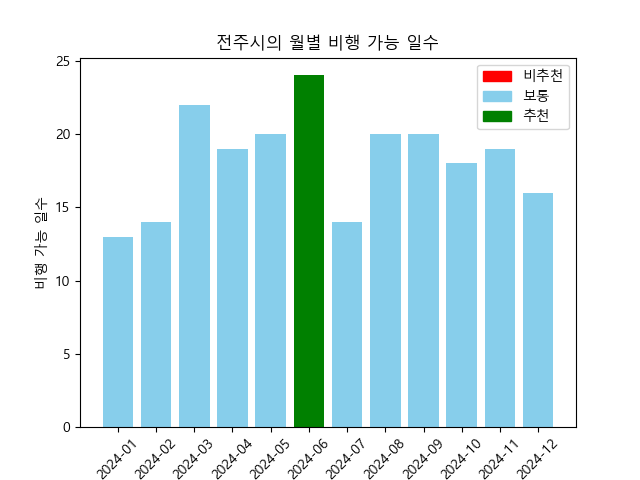
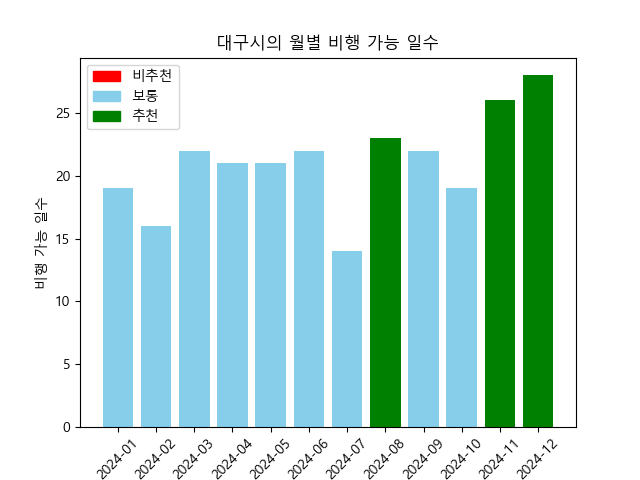
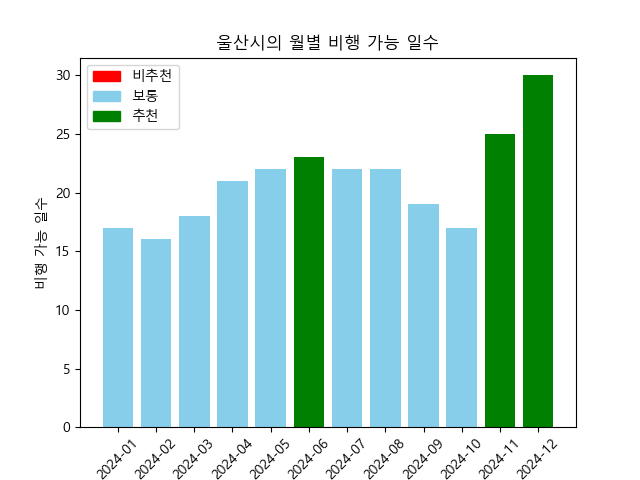
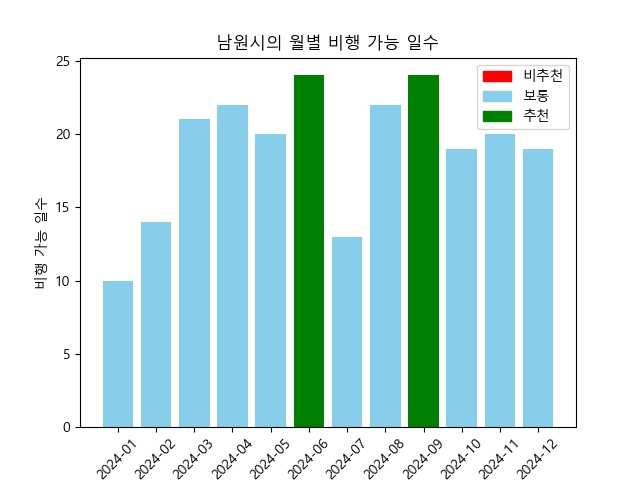
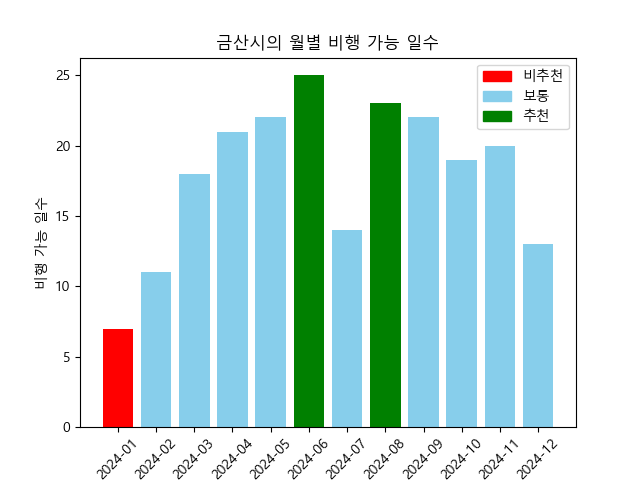
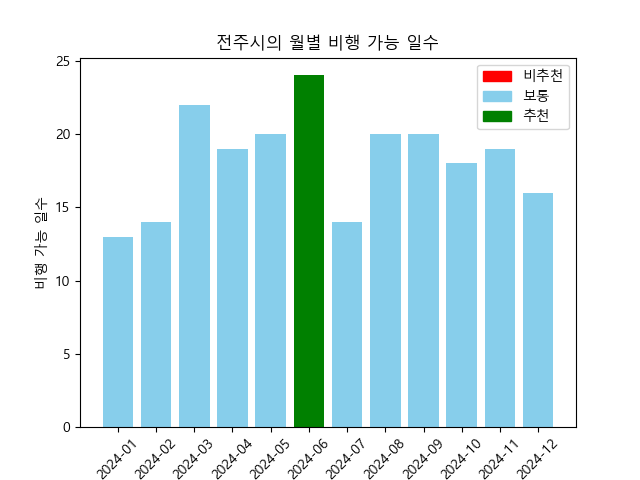
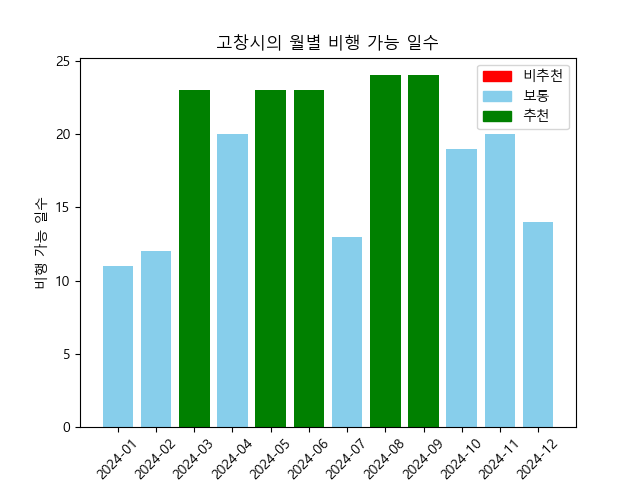
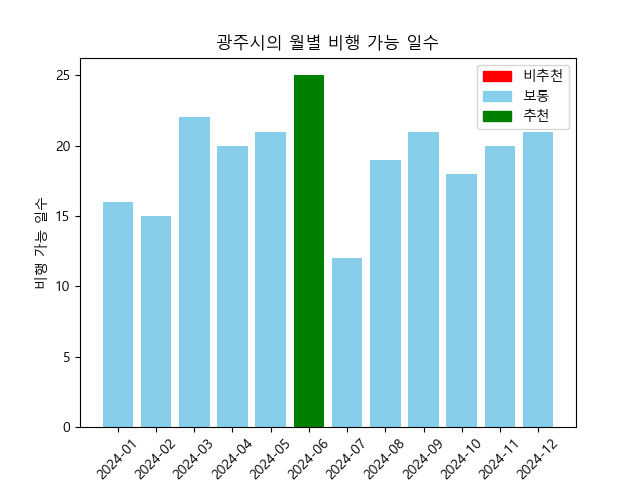
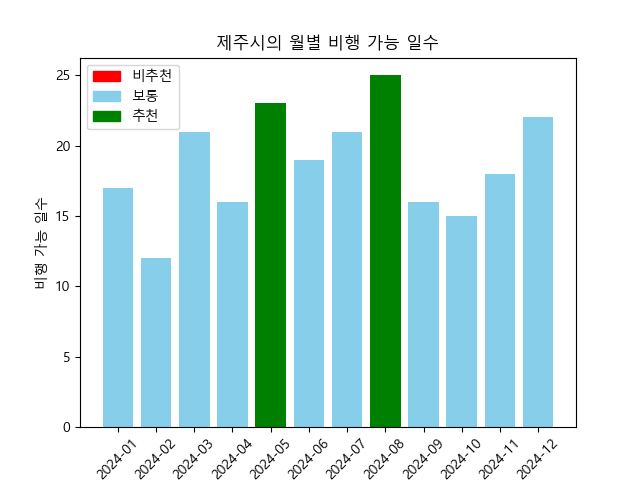
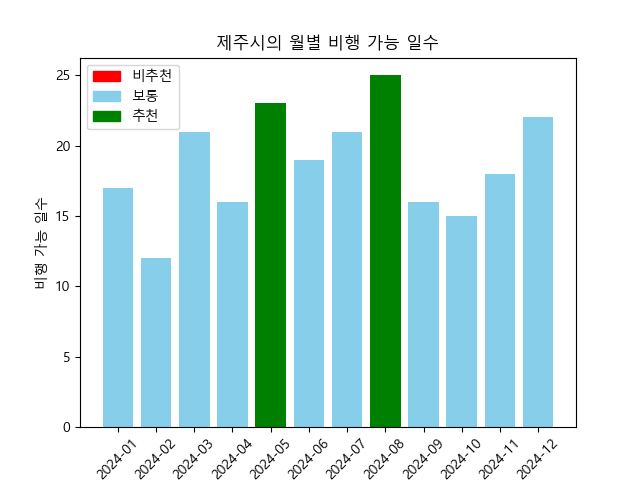
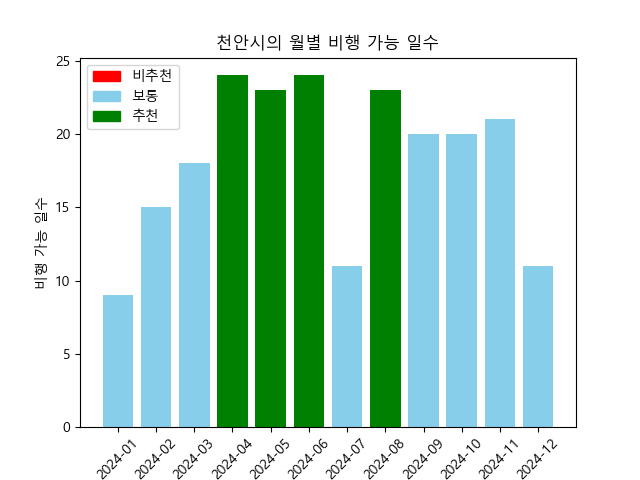
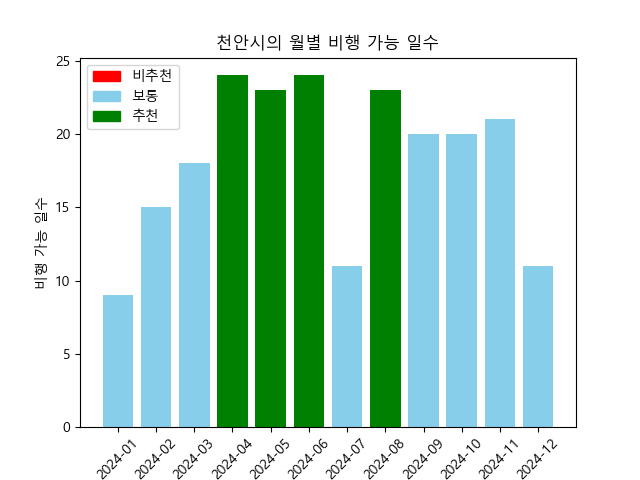
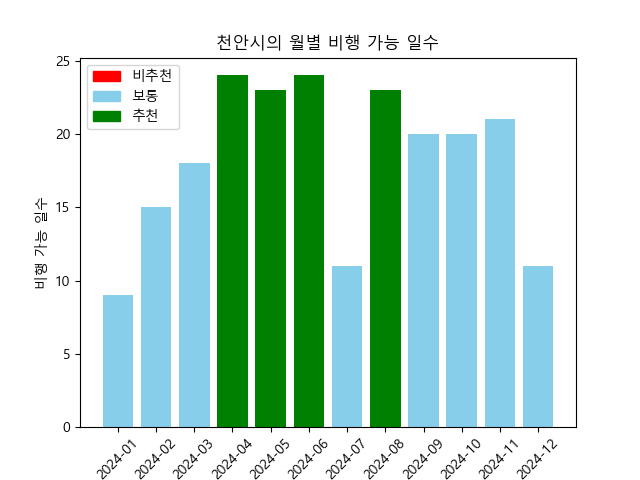
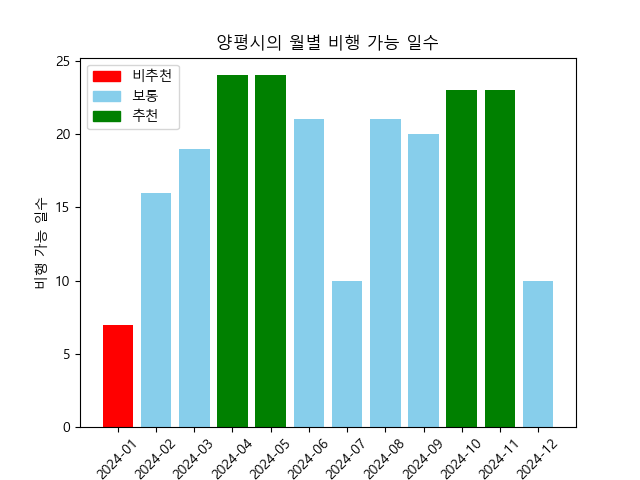
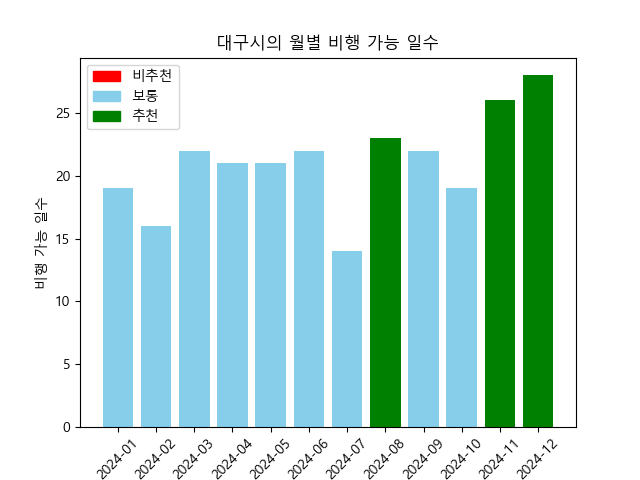
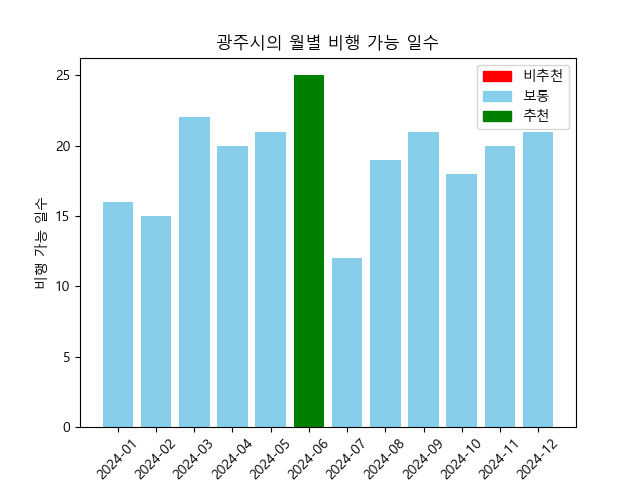
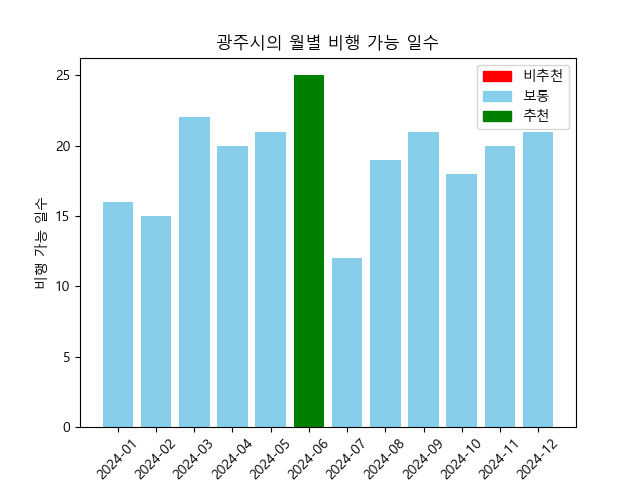
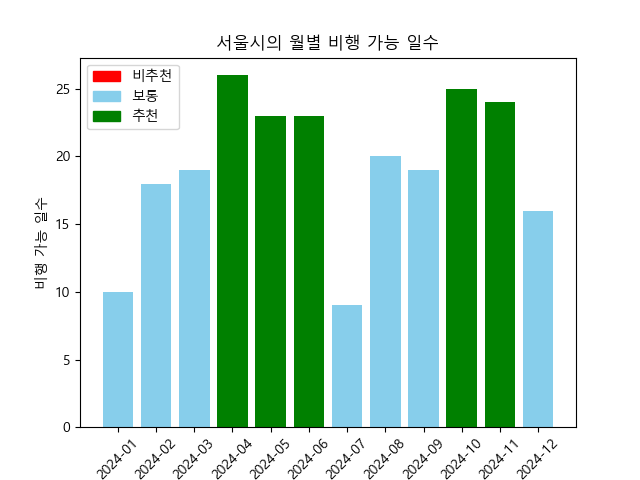
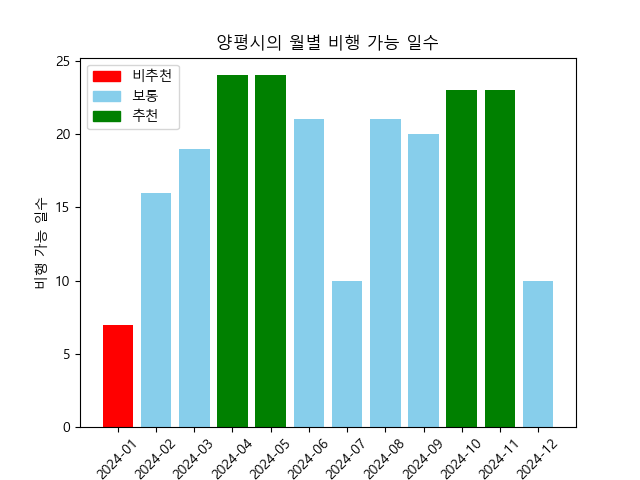
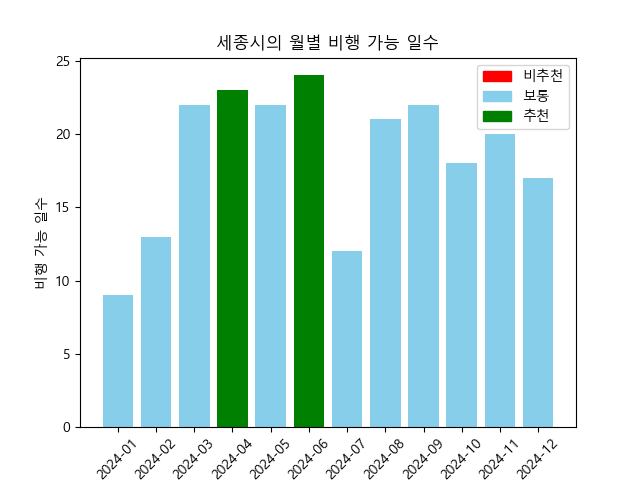
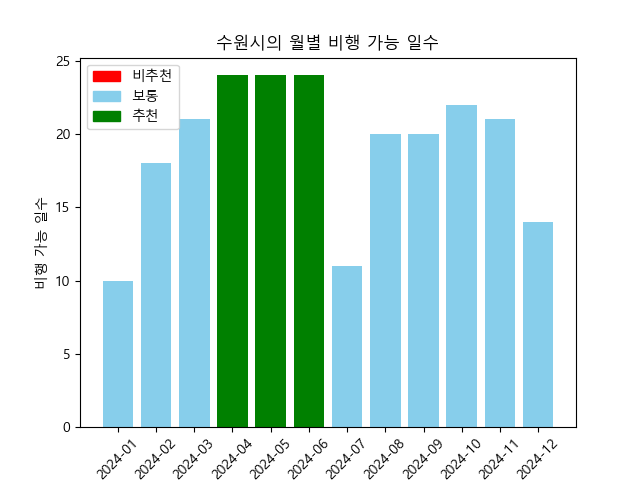
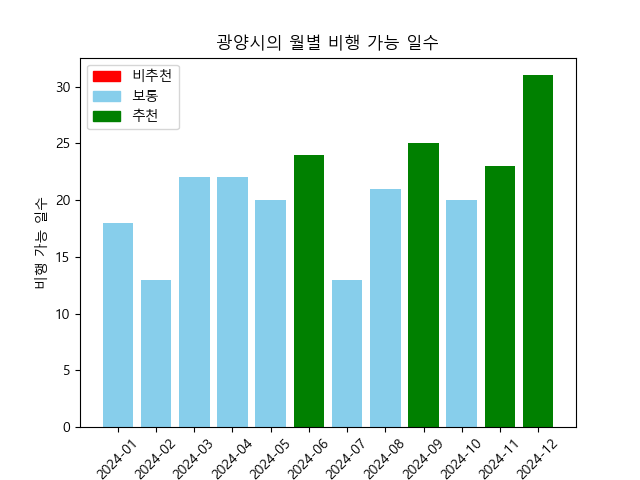
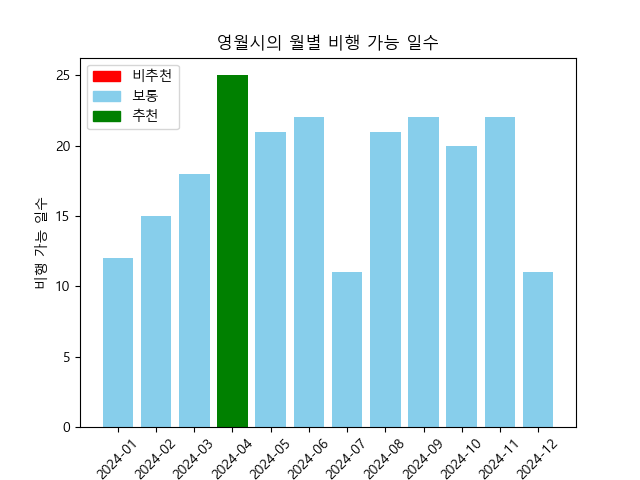
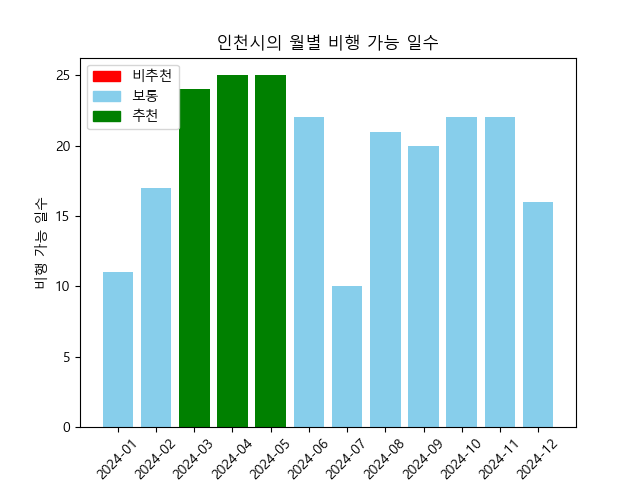
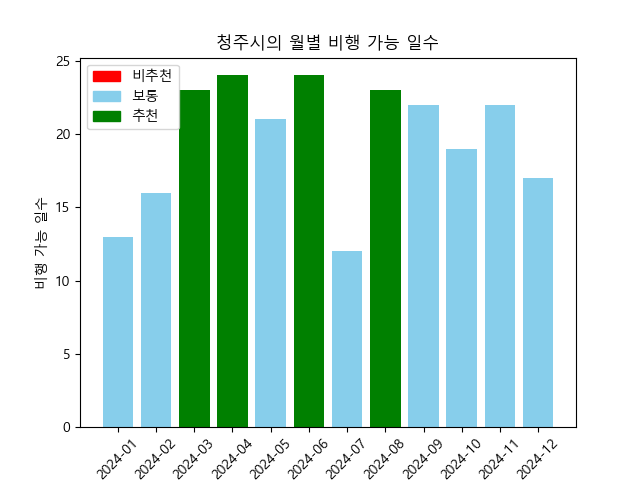
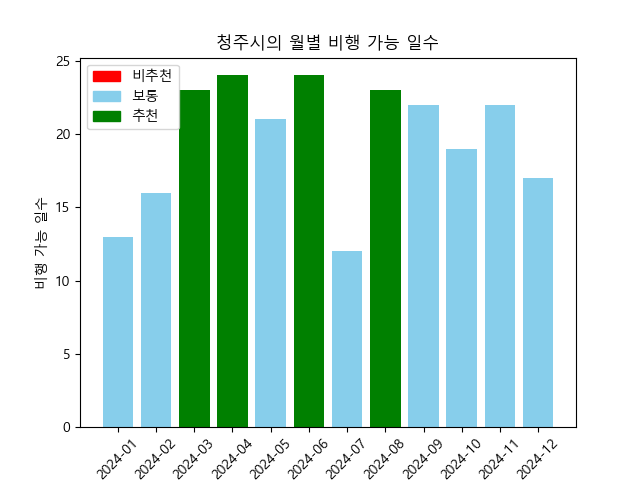
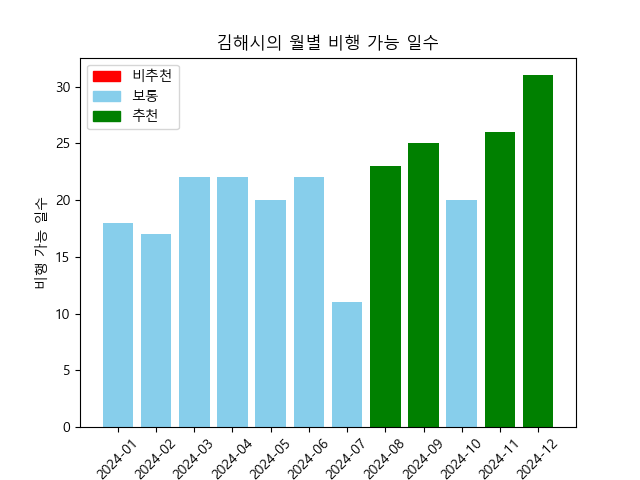
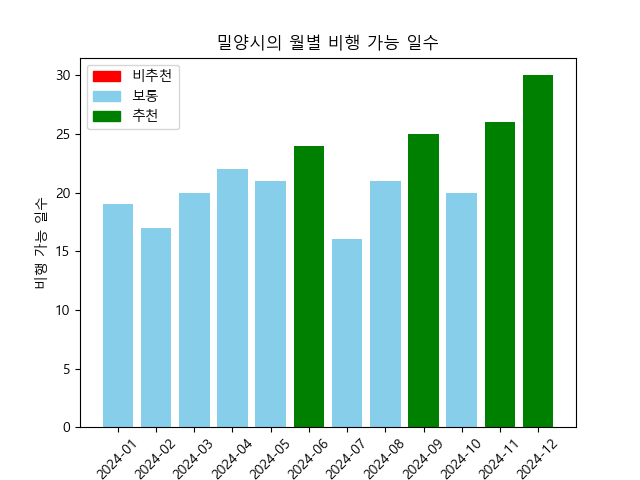
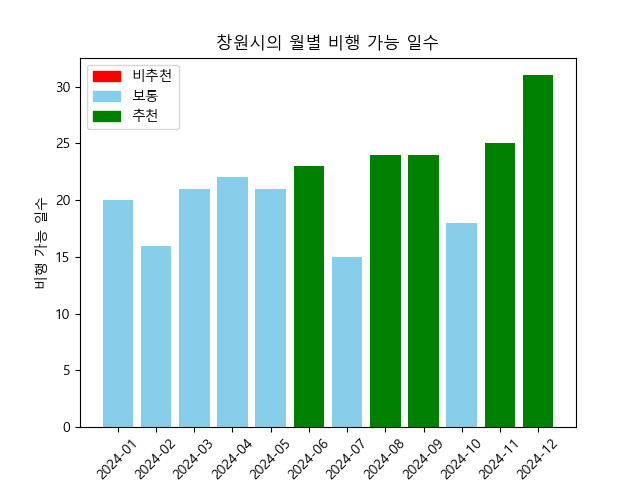
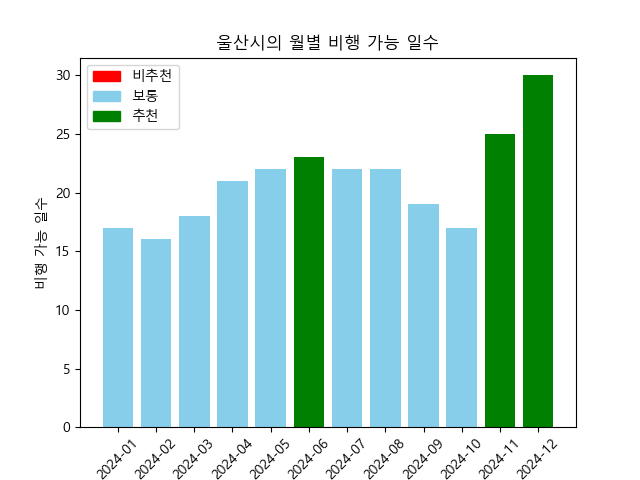
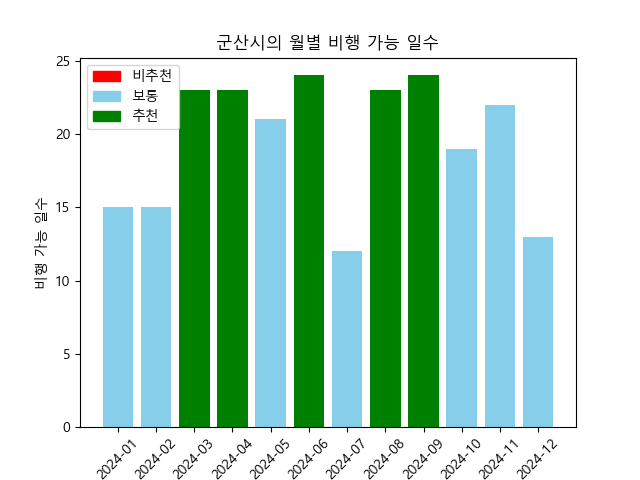
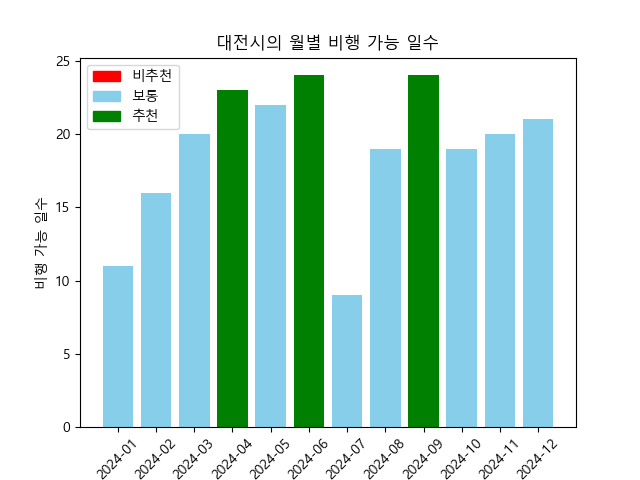
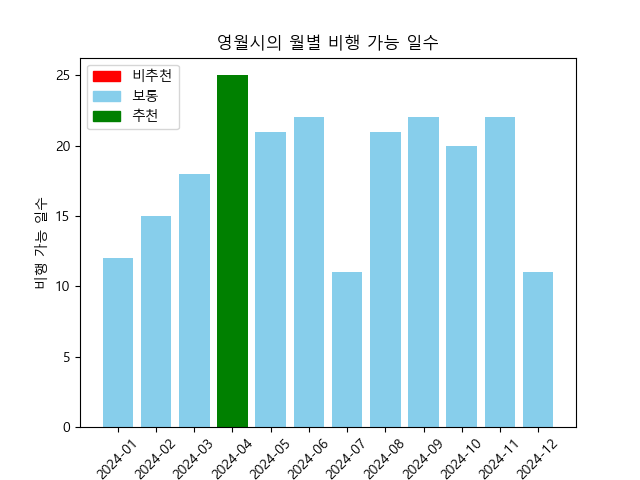
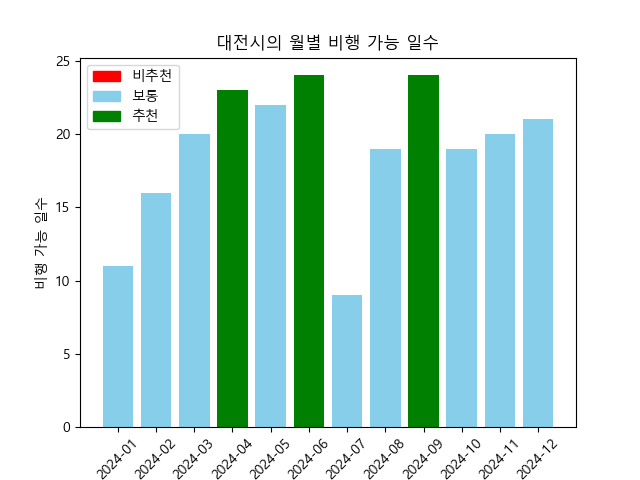
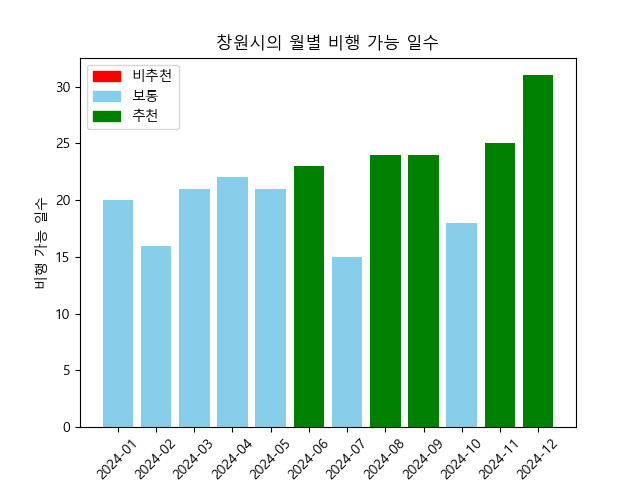
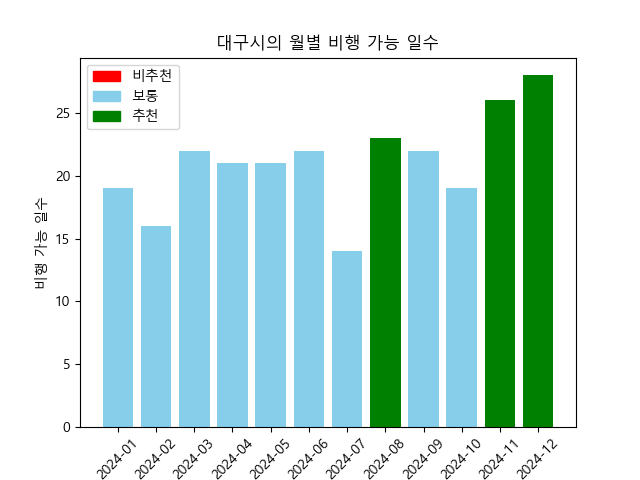
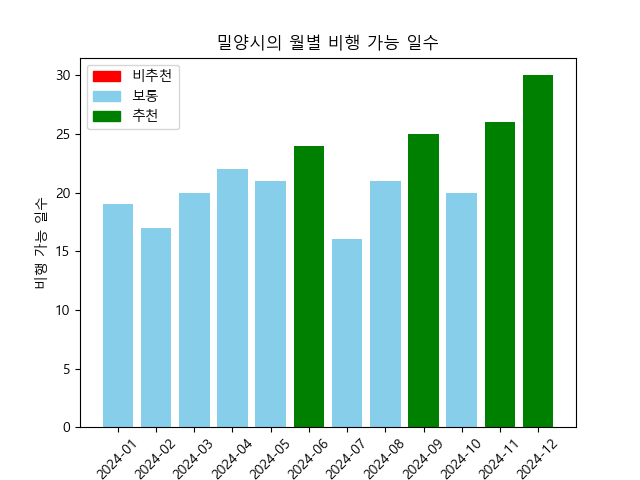
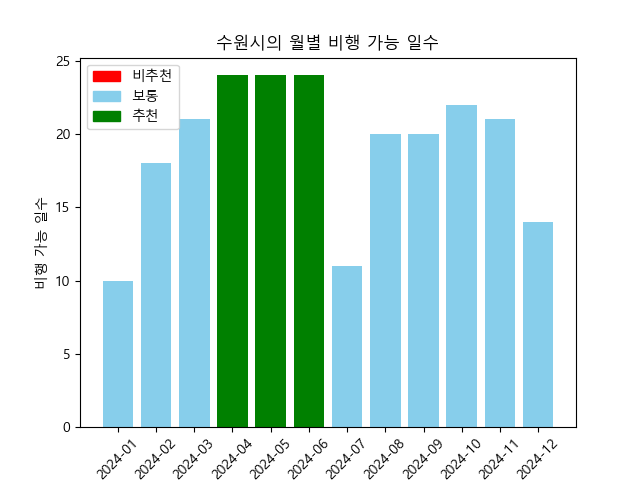
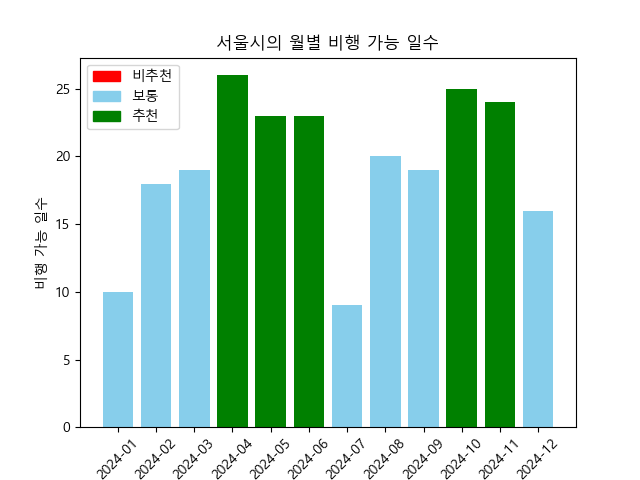
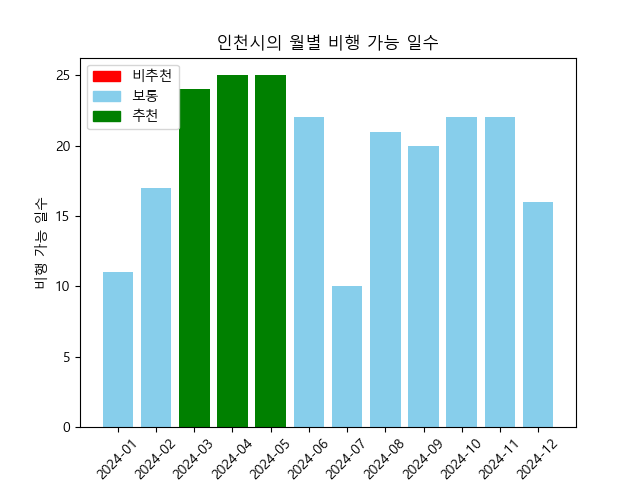
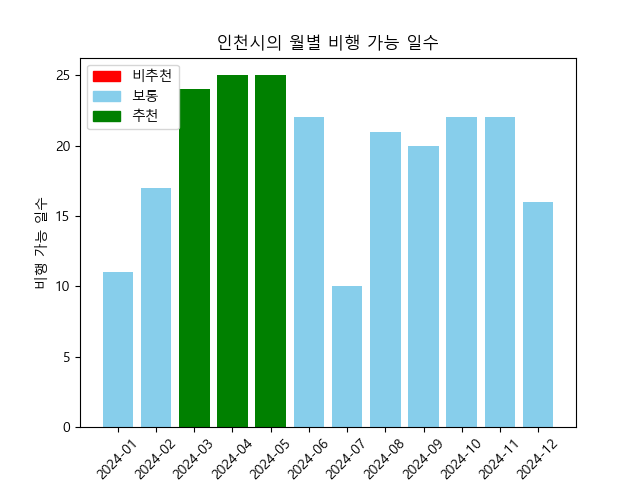
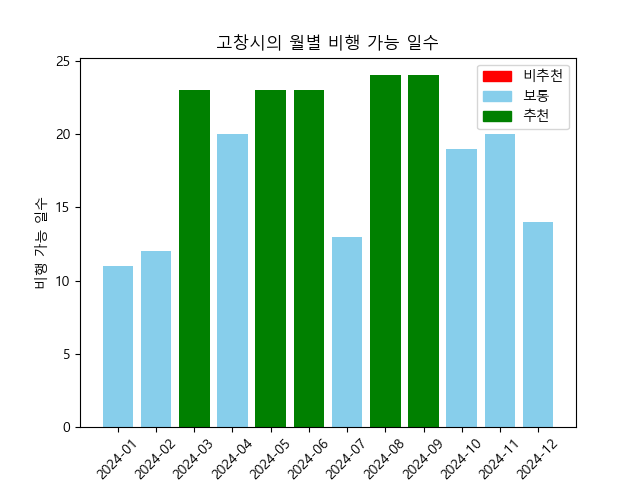
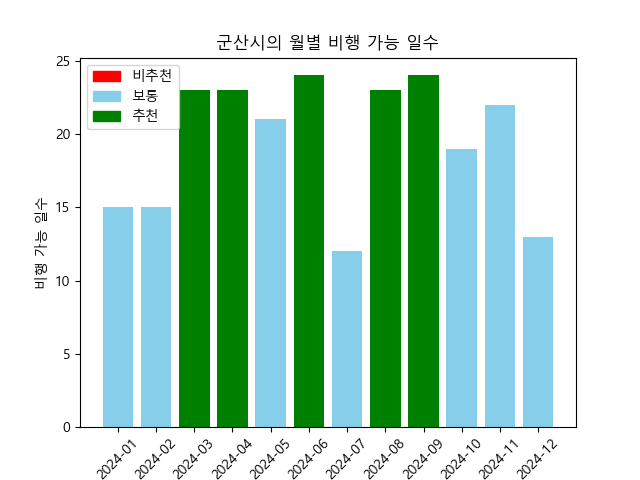
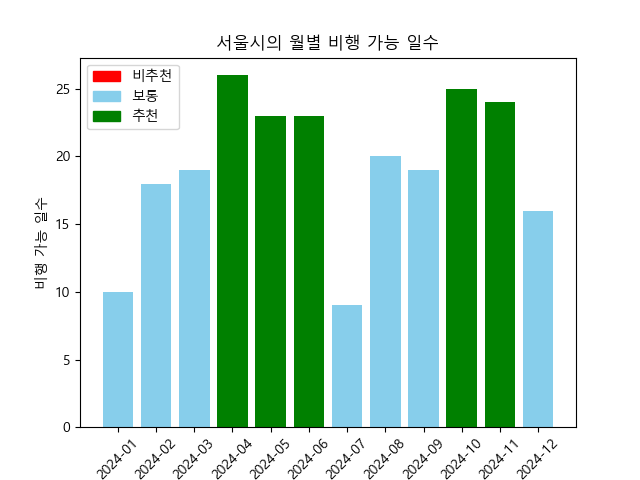
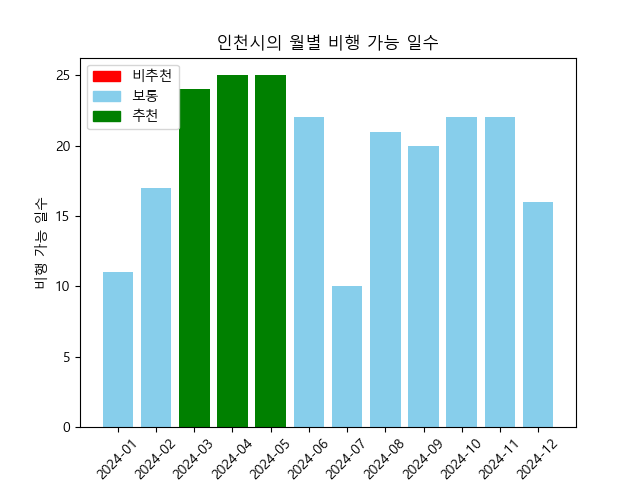
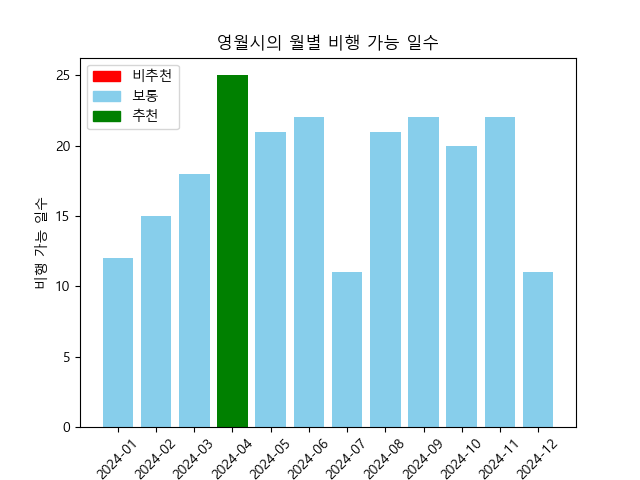
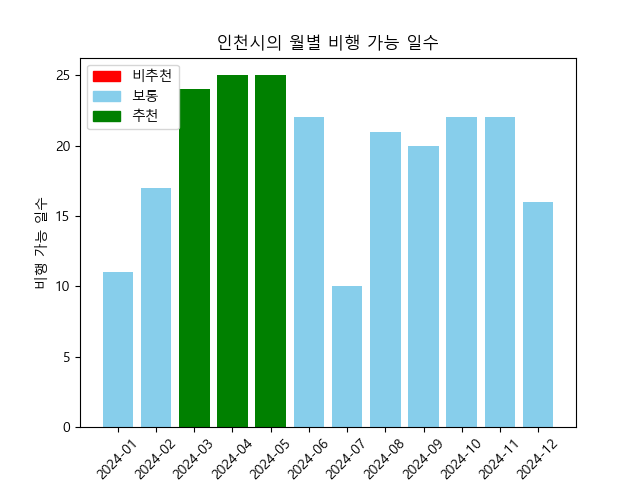
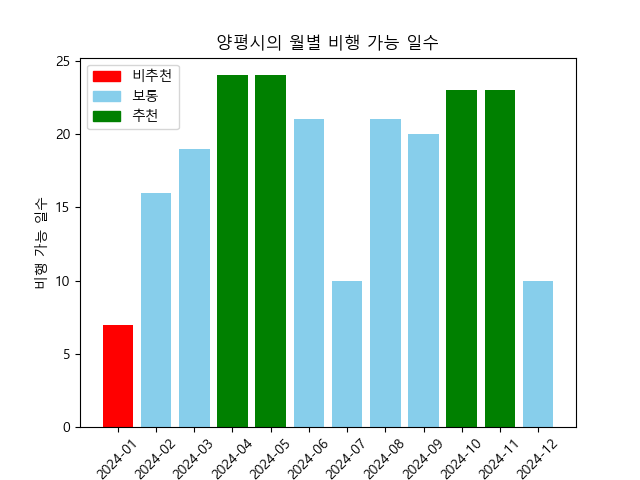
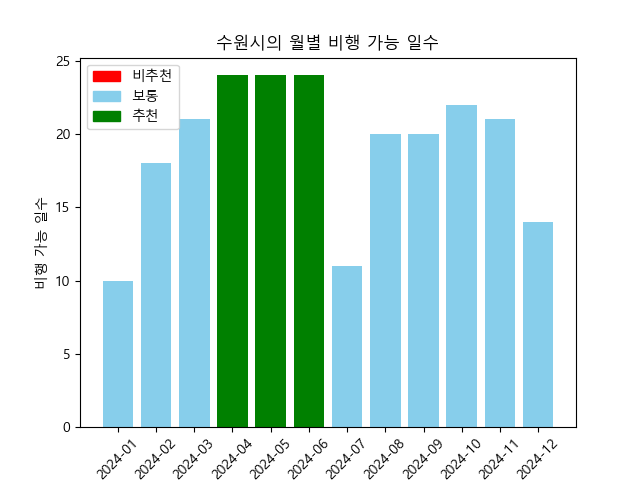
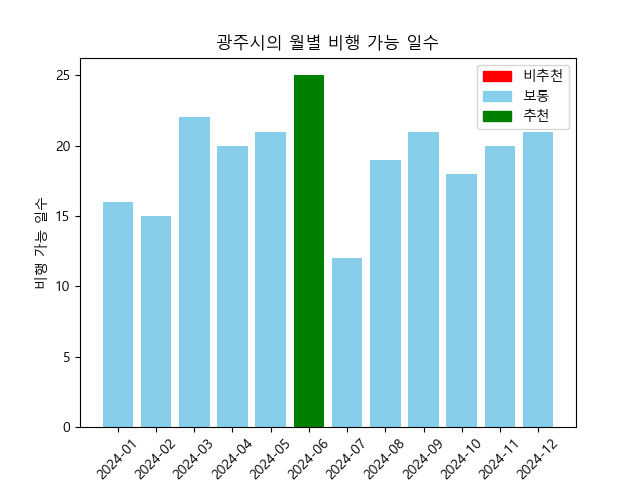
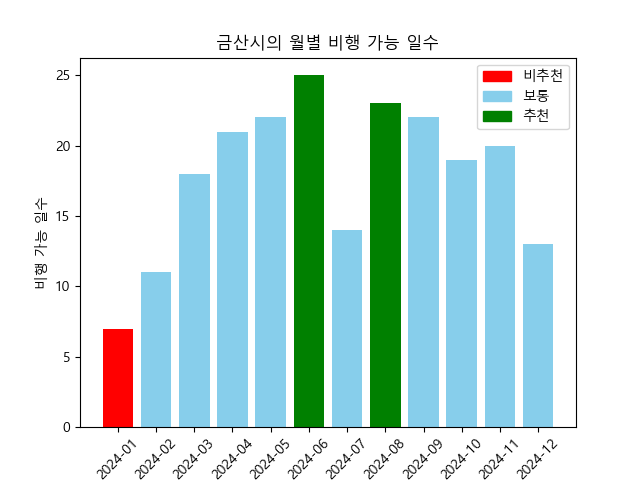
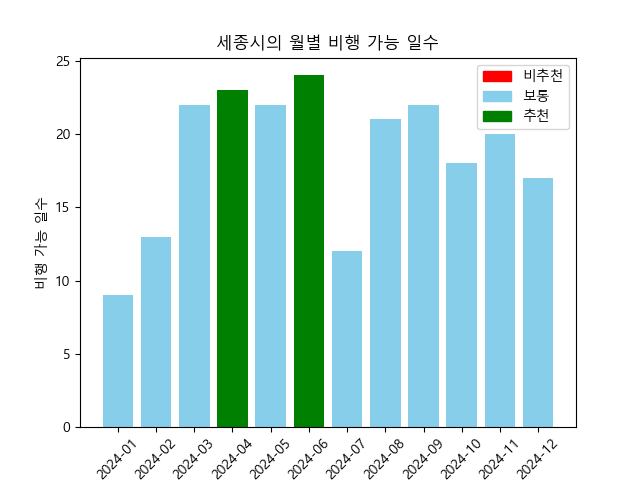
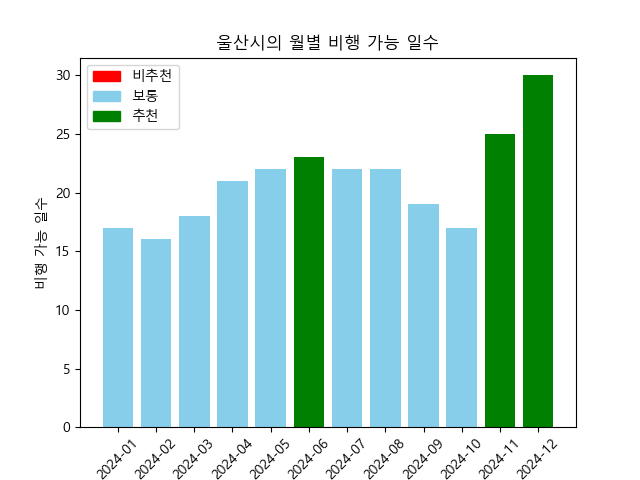
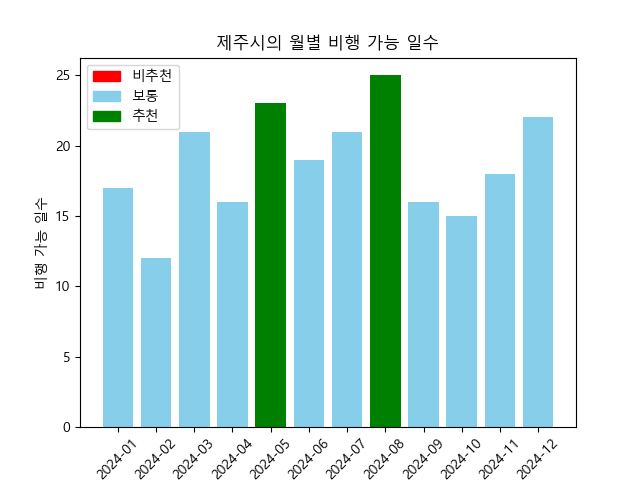
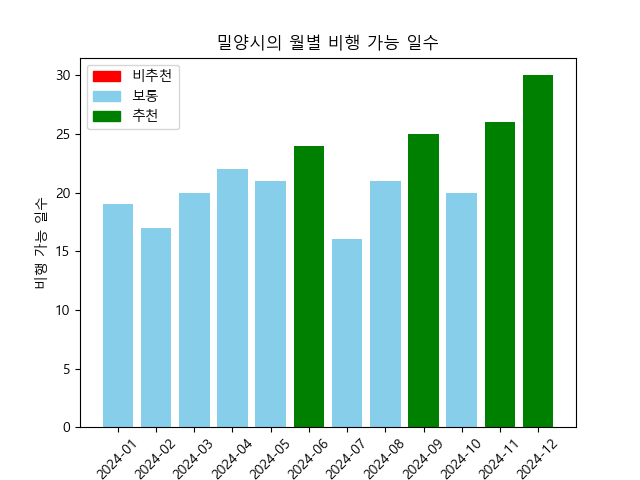
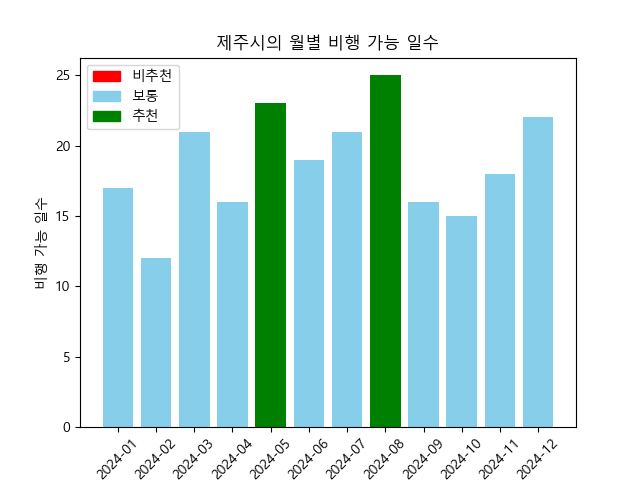
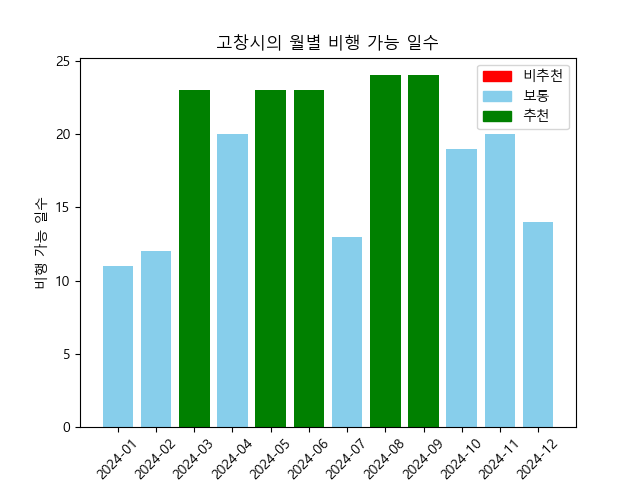
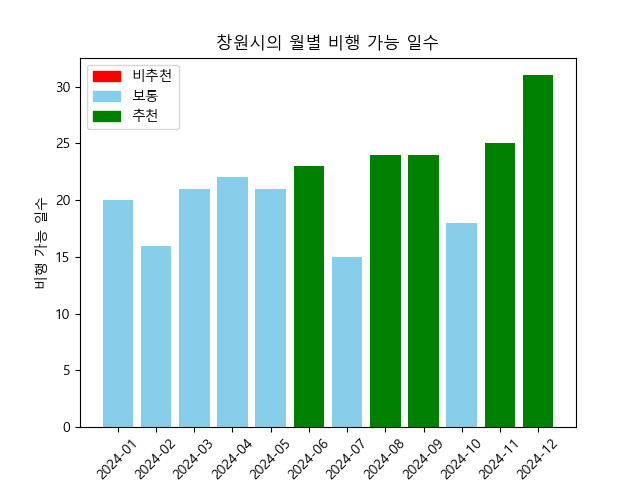
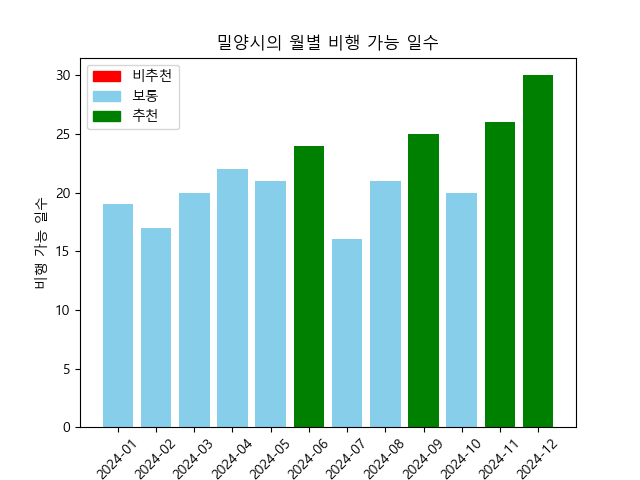
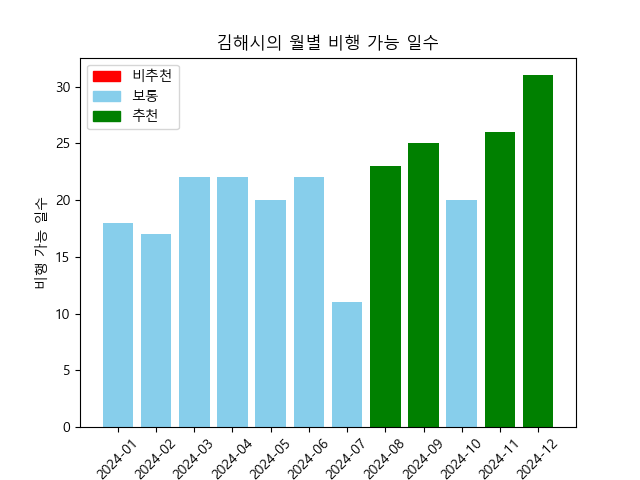
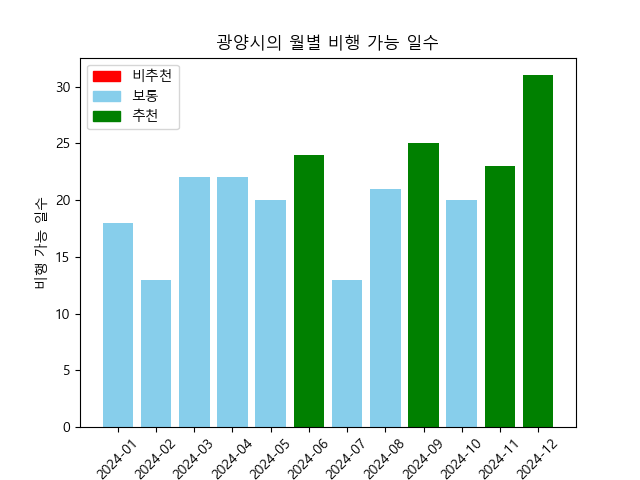
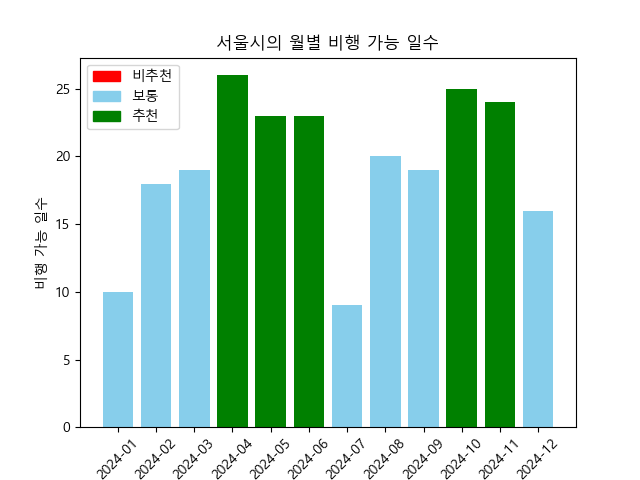
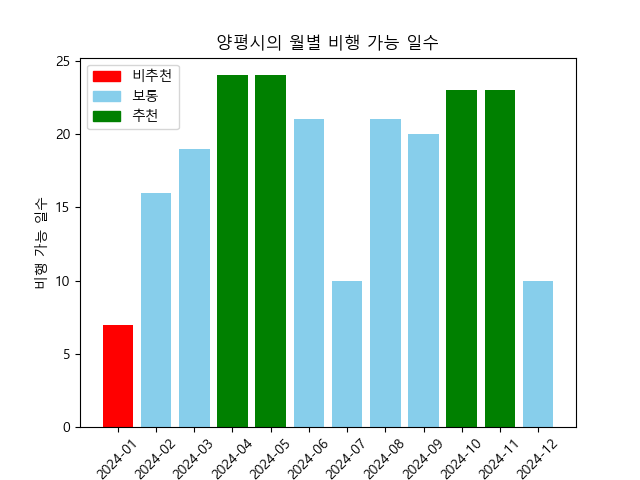
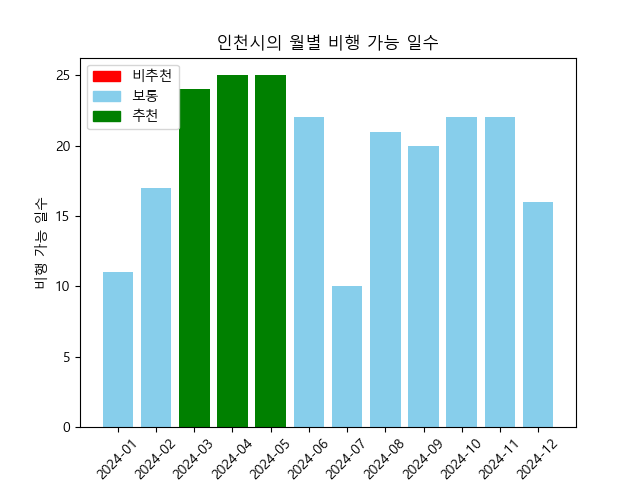
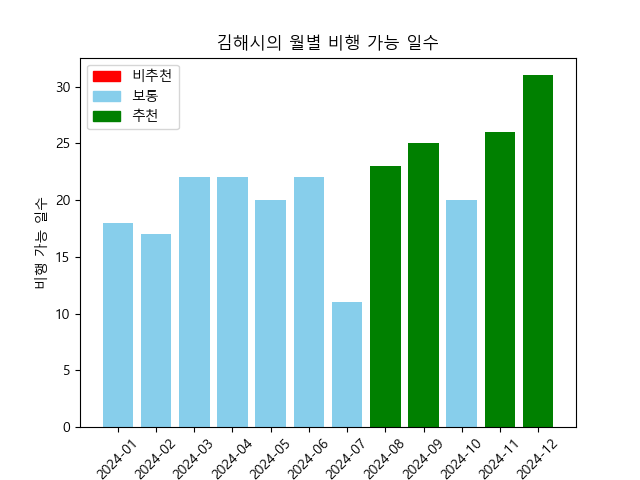
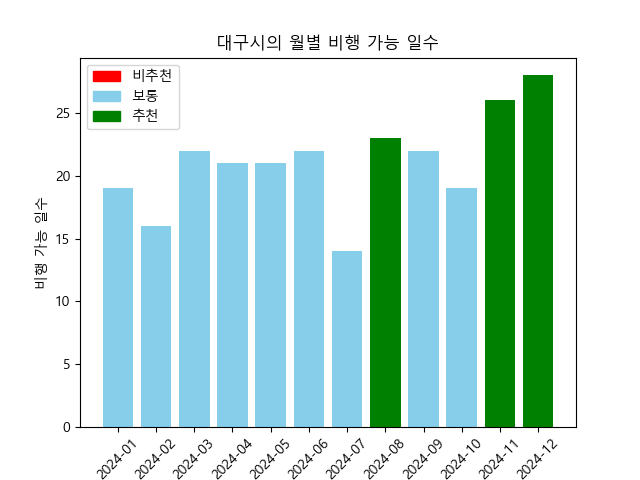
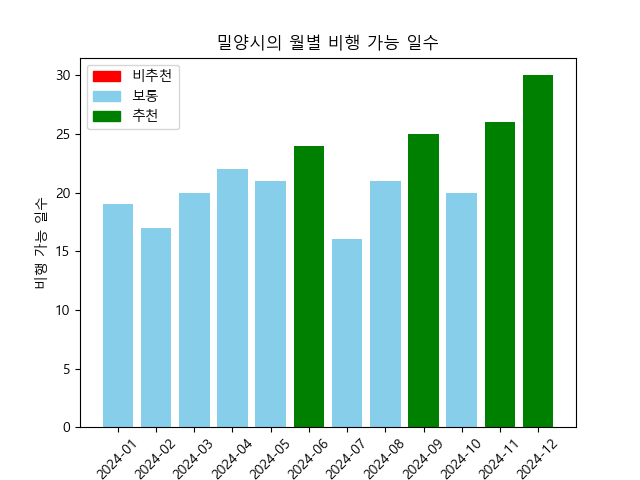
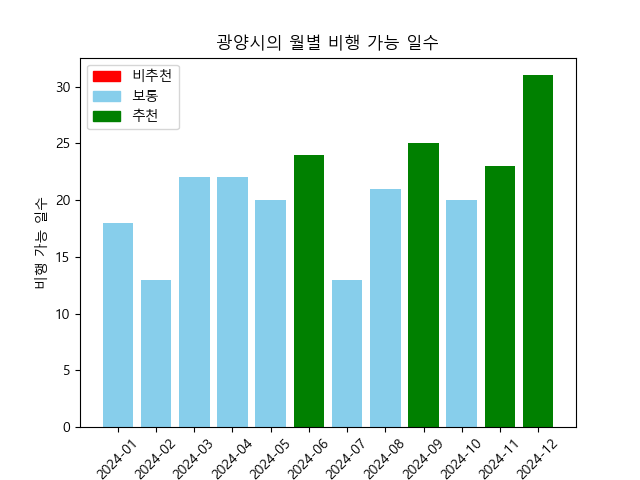
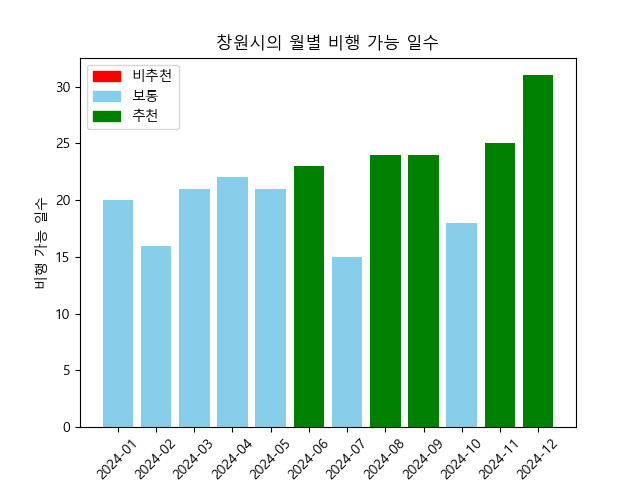
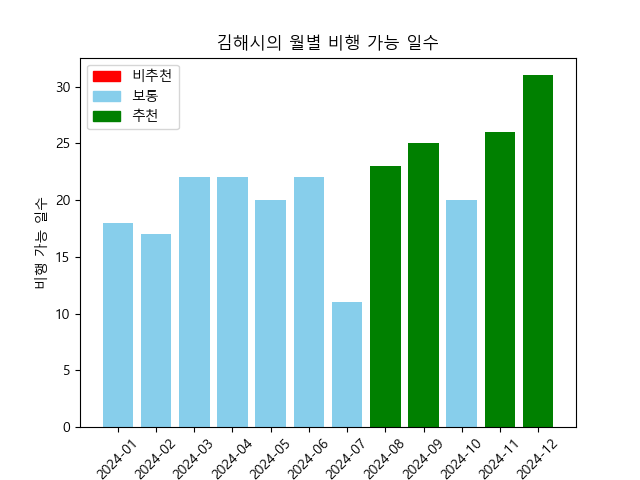

In [3]:
import os
import ast
import pandas as pd
import folium
import base64
from io import BytesIO
from fuzzywuzzy import process
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

# -------------------------
# CSV 파일 불러오기
# -------------------------
circle_table = pd.read_csv("C:/Users/user/Documents/에이콘아카데미/시각화 프로젝트/지역 좌표 데이터 csv파일/Circle_table.csv", encoding="utf-8")
NE_table = pd.read_csv("C:/Users/user/Documents/에이콘아카데미/시각화 프로젝트/지역 좌표 데이터 csv파일/NE_table.csv", encoding="utf-8")
weather_yn_df = pd.read_csv("C:/Users/user/Documents/에이콘아카데미/시각화 프로젝트/지역 좌표 데이터 csv파일/weather_yn_df.csv", encoding="utf-8")

# 공백 제거
weather_yn_df['stnNm'] = weather_yn_df['stnNm'].str.strip()
circle_table['위치'] = circle_table['위치'].str.strip()
NE_table['위치'] = NE_table['위치'].str.strip()

# -------------------------
# 괄호 내용 제거하여 간단한 지역명 만들기
# -------------------------
def clean_location(name):
    return re.sub(r"\(.*?\)", "", name).strip()

circle_table['clean_location'] = circle_table['위치'].apply(clean_location)
NE_table['clean_location'] = NE_table['위치'].apply(clean_location)

# 모든 지역명에 "시" 붙이기 (이미 "시"가 있는 경우 제외)
def add_city_suffix(name):
    if name and not name.endswith("시"):
        return name + "시"
    return name

weather_yn_df['stnNm'] = weather_yn_df['stnNm'].apply(add_city_suffix)
circle_table['clean_location'] = circle_table['clean_location'].apply(add_city_suffix)
NE_table['clean_location'] = NE_table['clean_location'].apply(add_city_suffix)

# -------------------------
# fuzzywuzzy로 stnNm과 clean_location 매칭
# -------------------------
valid_locations = list(set(circle_table['clean_location']).union(set(NE_table['clean_location'])))

def get_best_match(x):
    match = process.extractOne(x, valid_locations, score_cutoff=70)
    return match[0] if match else None

weather_yn_df['matched_location'] = weather_yn_df['stnNm'].apply(get_best_match)

# -------------------------
# 그래프 생성 함수 (캐싱)
# -------------------------
graph_cache = {}

def create_graph(region_name, data):
    """
    region_name: matched_location (또는 clean_location)
    data: weather_yn_df에서 해당 matched_location 행들
    """
    if region_name in graph_cache:
        return graph_cache[region_name]
    
    # 만약 데이터가 비어 있다면 "No data" 그래프 생성
    if data.empty:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=14, color='red')
        ax.set_title(f"{region_name}의 월별 비행 가능 일수")
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        fig, ax = plt.subplots()
        
        # 막대 색상: 7일 이하 = 빨간색, 23일 이상 = 초록색, 그 외 = 스카이 블루
        bar_colors = []
        for val in data['yn_month']:
            if val <= 7:
                bar_colors.append('red')
            elif val >= 23:
                bar_colors.append('green')
            else:
                bar_colors.append('skyblue')
        
        ax.bar(data['yyyymm'], data['yn_month'], color=bar_colors)
        ax.set_ylabel("비행 가능 일수")
        ax.set_title(f"{region_name}의 월별 비행 가능 일수")
        plt.xticks(rotation=45)
        
        # 범례
        red_patch = mpatches.Patch(color='red', label='비추천')
        skyblue_patch = mpatches.Patch(color='skyblue', label='보통')
        green_patch = mpatches.Patch(color='green', label='추천')
        ax.legend(handles=[red_patch, skyblue_patch, green_patch])
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    encoded_image = base64.b64encode(buffer.read()).decode()
    plt.close(fig)
    
    graph_cache[region_name] = encoded_image
    return encoded_image

# -------------------------
# Folium 지도 생성
# -------------------------
map_center = [37.0, 127.0]
if not circle_table.empty and pd.notna(circle_table.iloc[0]['위도']) and pd.notna(circle_table.iloc[0]['경도']):
    try:
        map_center = [float(circle_table.iloc[0]['위도']), float(circle_table.iloc[0]['경도'])]
    except:
        pass

m = folium.Map(location=map_center, zoom_start=7)

# -------------------------
# Circle 마커 (circle_table)
# -------------------------
def add_circle_markers(map_obj, circle_table, weather_yn_df):
    for _, row in circle_table.iterrows():
        region_name = row['clean_location'] if pd.notna(row['clean_location']) else row['위치']
        
        # weather_yn_df에서 matched_location이 region_name인 행 찾기
        matched_region_data = weather_yn_df[weather_yn_df['matched_location'] == region_name]
        
        # 모든 지역에 대해 그래프 생성
        graph_img = create_graph(region_name, matched_region_data)
        popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
        
        try:
            if pd.notna(row['위도']) and pd.notna(row['경도']):
                folium.Circle(
                    location=[float(row['위도']), float(row['경도'])],
                    radius=float(row['반경'])*1000 if pd.notna(row['반경']) else 500,
                    color="blue",
                    fill=True,
                    fill_color="blue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
        except Exception as e:
            print(f"Circle 마커 추가 실패: {e}")

# -------------------------
# Polygon 마커 (NE_table)
# -------------------------
def add_polygon_markers(map_obj, NE_table, weather_yn_df):
    for _, row in NE_table.iterrows():
        region_name = row['clean_location'] if pd.notna(row['clean_location']) else row['위치']
        
        if pd.notna(row['NE']) and row['NE'].strip() != "":
            try:
                ne_data = row['NE']
                ne_list = ast.literal_eval(ne_data) if isinstance(ne_data, str) else ne_data
                ne_list = [[float(lat), float(lon)] for lat, lon in ne_list]
                
                matched_region_data = weather_yn_df[weather_yn_df['matched_location'] == region_name]
                
                # 모든 지역에 대해 그래프 생성
                graph_img = create_graph(region_name, matched_region_data)
                popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
                
                folium.Polygon(
                    locations=ne_list,
                    color="blue",
                    fill=True,
                    fill_color="blue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
            except Exception as e:
                print(f"Polygon 마커 추가 실패: {e}")

# 지도에 Circle / Polygon 마커 추가
add_circle_markers(m, circle_table, weather_yn_df)
add_polygon_markers(m, NE_table, weather_yn_df)

# -------------------------
# 월별 TOP3 계산: matched_location 기준
# -------------------------
weather_yn_df['yyyymm'] = pd.to_datetime(weather_yn_df['yyyymm'], format='%Y-%m')
weather_yn_df['month'] = weather_yn_df['yyyymm'].dt.month

monthly_top3 = {}
for month in range(1, 13):
    df_month = weather_yn_df[weather_yn_df['month'] == month]
    grouped = df_month.groupby('matched_location', as_index=False)['yn_month'].sum()
    grouped = grouped.dropna(subset=['matched_location'])
    top3 = grouped.sort_values(by='yn_month', ascending=False)['matched_location'].head(3).tolist()
    monthly_top3[month] = top3

# -------------------------
# region_coords 만들기
# (1) circle_table: point 좌표
# (2) NE_table: polygon -> centroid
# -------------------------
region_coords = {}

# (1) circle_table (점)
for _, row in circle_table.iterrows():
    region = row['clean_location'] if pd.notna(row['clean_location']) else None
    if region and pd.notna(row['위도']) and pd.notna(row['경도']):
        region_coords[region] = [float(row['위도']), float(row['경도'])]

# (2) NE_table (폴리곤 -> 중심점)
for _, row in NE_table.iterrows():
    region = row['clean_location'] if pd.notna(row['clean_location']) else None
    ne_val = row['NE'] if pd.notna(row['NE']) else None
    if region and ne_val:
        try:
            polygon_data = ast.literal_eval(ne_val) if isinstance(ne_val, str) else ne_val
            polygon_points = [[float(lat), float(lon)] for lat, lon in polygon_data]
            if polygon_points:
                # 폴리곤 중심(centroid) 계산
                avg_lat = sum(pt[0] for pt in polygon_points) / len(polygon_points)
                avg_lon = sum(pt[1] for pt in polygon_points) / len(polygon_points)
                if region not in region_coords:
                    region_coords[region] = [avg_lat, avg_lon]
        except Exception as e:
            print(f"NE 데이터 파싱 실패 ({region}): {e}")

# -------------------------
# 월별 Top3를 주황색 원으로 표시 (FeatureGroup + LayerControl)
# 클릭 시 막대그래프 팝업 (데이터 없으면 No data 차트)
# -------------------------
for month in range(1, 13):
    fg = folium.FeatureGroup(name=f"{month}월 Top3")
    for region in monthly_top3[month]:
        if region in region_coords:
            coords = region_coords[region]
            region_data = weather_yn_df[weather_yn_df['matched_location'] == region]
            
            graph_img = create_graph(region, region_data)
            popup_html = f'<b>{region}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
            
            folium.Circle(
                location=coords,
                radius=5000,
                color='orange',
                fill=True,
                fill_color='orange',
                fill_opacity=0.5,
                popup=folium.Popup(popup_html, max_width=400)
            ).add_to(fg)
    fg.add_to(m)

# 레이어 컨트롤 추가
folium.LayerControl().add_to(m)

# -------------------------
# 결과 지도 저장
# -------------------------
m.save("combined_drone_map.html")
m
